# Example predictions of field particle correlation signatures
Here, we predict the signatures found in Howes 2017 (a kinetic alfven wave experiencing landau damping) as an example and generate relevant dispersion relations plots. 

Please, open a terminal, navigate to the install directory, make PLUME (run 'make all'), and run all the cells in this notebook to verify that everything is working correctly.

This notebook and related libraries serve as wrappers that make and call input files for plume by calling commands like "os.system('./plume.e *flnm*.in >> outlog' ". One can also use ./plume.e *flnm*.in to run plume.

If things are not behaving as expected, please check the outlog, where all plume output is saved when using this notebook.

*** Please check outlog for any warnings that PLUME might create and write to the outlog. These warnings *will not* be presented here in any way. Using this notebook, one may input parameters that allows the solver to run, but violates assumptions made when deriving the equations used by the solver ***

Note: Here, we make a class 'plumeinput' that contains input parameters which are accumulated throughout this notebook. Please be sure to run all above inputs containing 'plumeinput.*command*(*arguments*)', before making any 'lfpc.*function*(*arguments*)' call, as the wrapper class may need prior parameters.

Warning: these scripts only support using two species currently (Nov 9 2023)

## Load libraries, and enter parameters

In [1]:
import linfpclib.linfpc as lfpc
import linfpclib.linfpcplot as lp

import os
import numpy as np

In [2]:
#if a change is made to the above libraries, one can either restart the notebook, 
#  or call these functions to load changes in library
import importlib
importlib.reload(lfpc)
importlib.reload(lp)

<module 'linfpclib.linfpcplot' from '/Users/work/Documents/Research/LinKinTheory/LinFPCPaperAndData/PLUME/linfpclib/linfpcplot.py'>

In [3]:
filetag = 'howes2017' #this will be used to name all output files and folders
plumeinput = lfpc.plume_input(filetag)

In [4]:
betap=1
kperp=1.3
kpar=.05 #not specified in paper but when kpar << 1, exact number is not needed as dynamics don't change much in this regime
vtp=1.0E-4
nspec=2
nscan=1
option=1
nroot_max=20
use_map=True
writeOut=True

plumeinput.set_params(betap,kperp,kpar,vtp,nspec,nscan,option,\
                    nroot_max,use_map,writeOut)

In [5]:
#make ions
tauS=1.0
muS=1.0
alphS=1.0
Qs=1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 1) #be sure to specify species number

No species found, creating first species...


In [6]:
#make elecs
tauS=1
muS=1836
alphS=1.0
Qs=-1.0
Ds=1.0
vvS=0.
plumeinput.make_species(tauS, muS, alphS, Qs, Ds, vvS, spec_n = 2)

Appending species to list. Total species is now  2


In [7]:
#given the fixed above parameters, PLUME solves the dispersion relation for values over the range of omega
#and gamma given below. It initializes a grid (either log spaced or evenly spaced) and does it's best to find 
#all roots in this range. For each grid point, gradient descent is used to try and find a nearby solution.
#Sometimes this results in no found root. Sometimes roots are found outside the sweep range 
#(both close to the range, and very far from it)
loggridw=False
omi=-1.0E-02
omf=1.0E-0
gami=-2.0E-01
gamf=2.0E-01
positive_roots=True
plumeinput.set_maps(loggridw,omi,omf,gami,gamf,positive_roots)

In [8]:
inputfldr= 'input/'+filetag+'/' #folder where all generated input files will be placed
cmd = 'mkdir '+inputfldr
print(cmd)
os.system(cmd) #256 exit code means folder already exits (no need to worry), 0 means it sucessfully made the folder

mkdir input/howes2017/


mkdir: input/howes2017/: File exists


256

## Find roots

In [9]:
roots = lfpc.compute_roots(plumeinput,inputfldr+'roots',filetag)

OVERWRITING OPTION; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Rewriting file...
mkdir data/howes2017
./plume.e input/howes2017/roots.in >> outlog


mkdir: data/howes2017: File exists


Reading roots from  data/howes2017/dispersion_howes2017.roots


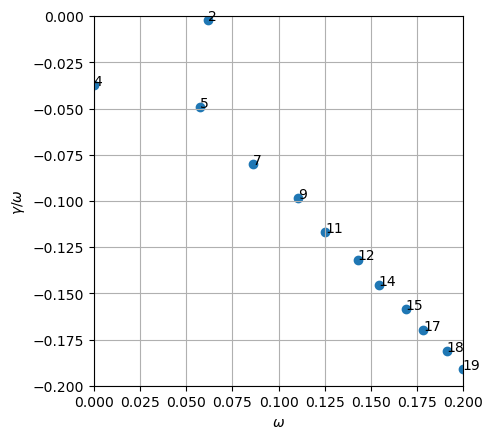

In [10]:
import matplotlib.pyplot as plt
oms = [rt.real for rt in roots]
gams = [rt.imag for rt in roots]
lbls = [_i for _i in range(0,len(oms))]

plt.figure()
plt.scatter(oms,gams)
plt.xlim(0,.2)
plt.ylim(-.2,0)
for _i, txt in enumerate(lbls):
    plt.gca().annotate(txt, (oms[_i], gams[_i]))
plt.gca().set_aspect('equal')
plt.grid()
plt.xlabel(r"$\omega$") #normalized as in PLUME 
plt.ylabel(r"$\gamma / \omega$")
plt.show()

## Select root to compute dispersion relation as a function of selected variable and predict damping contribution by mechanisms 
The following block of code will plot the dispersion relation for the root at index 2

In [11]:
rootidx = 2
roots[rootidx] #later we show that this is the alfven root

(0.061719-0.0022112j)

In [12]:
importlib.reload(lfpc)
sweepvarkey = 'kperp' #change this variable to sweep over other variables
                      #wrapper currently supports kperp, kpar, betap, and vtp sweeps
                      #see readme for all available sweep options
sweepmin = .1
sweepmax = 100
root = roots[rootidx]
inputflnm = inputfldr+'sweep'
outputname = 'sweep'
sweep = lfpc.make_sweeps_that_branch_from_params(plumeinput,sweepvarkey,sweepmin,sweepmax,root,inputflnm,outputname,outlog='outlog',nsamps=50)

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Rewriting file...
./plume.e input/howes2017/sweepsweep1.in >> outlog
Rewriting file...
./plume.e input/howes2017/sweepsweep2.in >> outlog
Loading  data/howes2017/sweepsweep1_kperp_1300_100000.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Loading  data/howes2017/sweepsweep2_kperp_1300_100.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Combining data and returning as 1 sweep...


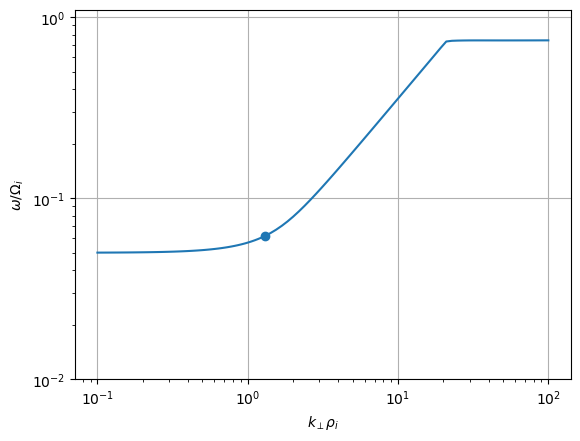

In [13]:
#'verify' that we have the alfven branch solution 
#(often more analysis will be needed, but sometimes one can use intuition to select the correct branch)
#(for example, here we know it is the alfven branch solution as the wave goes dispersive at kperprhoi~1)
#(an b/c it evenutally 'hits a resonance and flattens out')
#(later this is verified by getting an accurate FPC prediction )
plt.figure()
xplot = sweep['kperp']
yplot = sweep['w']
plt.loglog(xplot,yplot)
plt.scatter(plumeinput.params['kperp'],roots[rootidx].real)
plt.xlabel(r"$k_\perp \rho_i$")
plt.ylabel(r"$\omega / \Omega_i$")
plt.ylim(0.01,1.1)
plt.grid()
plt.show()

In [14]:
#other keys that can be plotted as a function of sweepvarkey
print(sweep.keys())

dict_keys(['kperp', 'kpar', 'betap', 'vtp', 'w', 'g', 'bxr', 'bxi', 'byr', 'byi', 'bzr', 'bzi', 'exr', 'exi', 'eyr', 'eyi', 'ezr', 'ezi', 'ux1r', 'ux1i', 'uy1r', 'uy1i', 'uz1r', 'uz1i', 'ux2r', 'ux2i', 'uy2r', 'uy2i', 'uz2r', 'uz2i', 'n1r', 'n1i', 'n2r', 'n2i', 'ps1', 'ps2', 'p1ld1', 'p1ld2', 'p1ttd1', 'p1ttd2', 'p1n0', 'p1cd', 'p2ld1', 'p2ld2', 'p2ttd1', 'p2ttd2', 'p2n0', 'p2cd'])


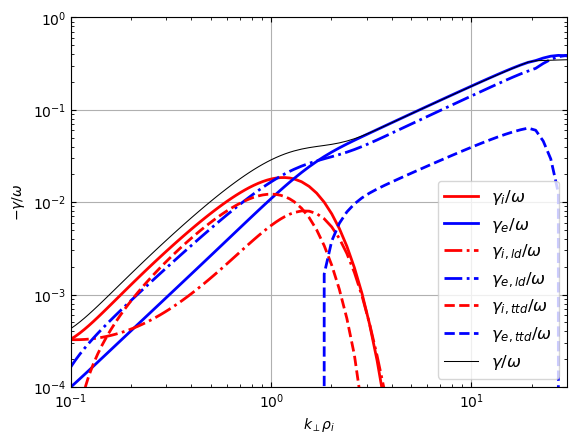

In [15]:
#plot power rate due to different mechanisms/ susc tensor 'splits' 
#INTO the particles in units of gamma/omega

#note: here, a positive power means particles are gaining energy, 
#i.e. the wave is losing energy
#This is the opposite convention used above for the dispersion relation

#note: as values can be positive and negative, 
#we separate into positive and negative ararys to plot using a log scale
#Here, we only plot positive values of power

#p1 is species 1, ions. p2 is species 2, electrons


ildposh = sweep['p1ld1']+sweep['p1ld2']
ildnegh = -1*(sweep['p1ld1']+sweep['p1ld2'])
eldposh = (sweep['p2ld1']+sweep['p2ld2'])
eldnegh = -1*(sweep['p1ld1']+sweep['p1ld2'])

ittdposh = sweep['p1ttd1']+sweep['p1ttd2']
ittdnegh = -1*(sweep['p1ttd1']+sweep['p1ttd2'])
ettdposh = (sweep['p2ttd1']+sweep['p2ttd2'])
ettdnegh = -1*(sweep['p2ttd1']+sweep['p2ttd2'])

itoth = sweep['ps1']
etoth = sweep['ps2']

gamma_over_omega = []
for _i in range(0,len(sweep['kperp'])):
    gamma_over_omega.append(-sweep['g'][_i]/sweep['w'][_i])
gamma_over_omega = np.asarray(gamma_over_omega)

ildpose = sweep['p1ld1']+sweep['p1ld2']
ildnege = -1*(sweep['p1ld1']+sweep['p1ld2'])
eldpose = (sweep['p2ld1']+sweep['p2ld2'])
eldnege = -1*(sweep['p1ld1']+sweep['p1ld2'])

ittdpose = sweep['p1ttd1']+sweep['p1ttd2']
ittdnege = -1*(sweep['p1ttd1']+sweep['p1ttd2'])
ettdpose = (sweep['p2ttd1']+sweep['p2ttd2'])
ettdnege = -1*(sweep['p2ttd1']+sweep['p2ttd2'])

itote = sweep['ps1']
etote = sweep['ps2']

gamma_over_omegae = []
for _i in range(0,len(sweep['kperp'])):
    gamma_over_omegae.append(-sweep['g'][_i]/sweep['w'][_i])
gamma_over_omegae = np.asarray(gamma_over_omegae)

fig = plt.plot(figsize=(8,8))
plt.loglog(sweep['kperp'],itoth,color='red',label=r'$\gamma_i/\omega$',ls='-',lw=2)
plt.loglog(sweep['kperp'],etoth,color='blue',label=r'$\gamma_e/\omega$',ls='-',lw=2)
plt.loglog(sweep['kperp'],ildposh,color='red',label=r'$\gamma_{i,ld}/\omega$',ls='-.',lw=2)
plt.loglog(sweep['kperp'],eldposh,color='blue',label=r'$\gamma_{e,ld}/\omega$',ls='-.',lw=2)
plt.loglog(sweep['kperp'],ittdposh,color='red',label=r'$\gamma_{i,ttd}/\omega$',ls='--',lw=2)
plt.loglog(sweep['kperp'],ettdposh,color='blue',label=r'$\gamma_{e,ttd}/\omega$',ls='--',lw=2)
plt.loglog(sweep['kperp'],gamma_over_omega,color='black',label=r'$\gamma/\omega$',lw=.75)

plt.legend(fontsize=12)

plt.tick_params(axis='both', which='both', direction='in',top=True, bottom=True, right=True, left=True)
plt.grid()

plt.ylabel(r'$-\gamma/\omega$')
plt.xlabel(r'$k_\perp \rho_i$')

plt.ylim(0.0001,1)
plt.xlim(0.1,30)

plt.show()
plt.close()

## Sweep over two variables from selected root

In [130]:
importlib.reload(lfpc)
importlib.reload(lp)


var1key = 'kperp'
var2key = 'kpar'

var1min = 0.5
var1max = 5
var2min = 0.5
var2max = 5

stylenum1 = 0
stylenum2 = 0

inputflnm = inputfldr+'2varsweep'
outputname = '2varsweep'

sweep2d = lfpc.branch_2var_scan_from_root(plumeinput,stylenum1,stylenum2,var1key,var1min,var1max,var2key,var2min,var2max,root,inputflnm,outputname,verbose=True,outlog='outlog',nsamps=20)
    

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Rewriting file...
./plume.e input/howes2017/2varsweepsweep1.in >> outlog
Rewriting file...
./plume.e input/howes2017/2varsweepsweep2.in >> outlog
Rewriting file...
./plume.e input/howes2017/2varsweepsweep3.in >> outlog
Rewriting file...
./plume.e input/howes2017/2varsweepsweep4.in >> outlog
Loading  data/howes2017/2varsweepsweep1_kperp_kpar.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Loading  data/howes2017/2varsweepsweep2_kperp_kpar.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Loading  data/howes2017/2varsweepsweep3_kperp_kpar.mode1 ...
 TODO: write load_plume_sweep_nspec...
If unsure, please check vars.f90 (change requires recompile)
If both are true, new_low_n is used
Loading  data/howes20

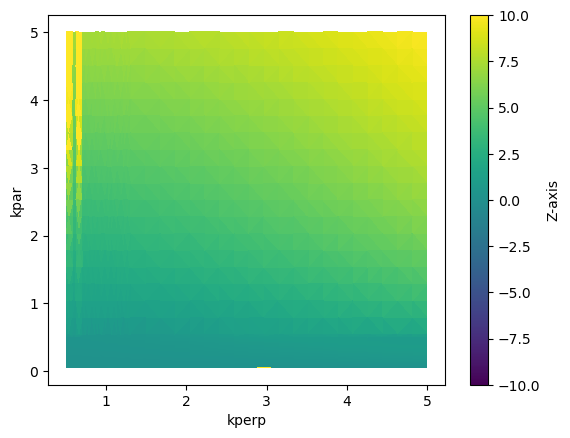

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.colors import LogNorm

x = sweep2d['kperp']
y = sweep2d['kpar']
z = sweep2d['w']

triang = Triangulation(x, y)
plt.tripcolor(triang, z, cmap='viridis', edgecolors='none', vmin=-10,vmax=10)
cbar = plt.colorbar(label='Z-axis', norm=LogNorm())

plt.xlabel('kperp')
plt.ylabel('kpar')
plt.show()



In [ ]:
importlib.reload(lfpc)
importlib.reload(lp)


var1key = 'betap'
var2key = 'alphS'

var1min = 0.1
var1max = 10
var2min = 0.1
var2max = 10

stylenum1 = 0
stylenum2 = 1

inputflnm = inputfldr+'2varsweep'
outputname = '2varsweep'

sweep2d_2 = lfpc.branch_2var_scan_from_root(plumeinput,stylenum1,stylenum2,var1key,var1min,var1max,var2key,var2min,var2max,root,inputflnm,outputname,verbose=True,outlog='outlog',nsamps=50)
    

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Rewriting file...
./plume.e input/howes2017/2varsweepsweep1.in >> outlog
Rewriting file...
./plume.e input/howes2017/2varsweepsweep2.in >> outlog
Rewriting file...
./plume.e input/howes2017/2varsweepsweep3.in >> outlog


In [ ]:
sweep2d_2.keys()

In [ ]:
for _val in sweep2d_2['g']:
    print(_val)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.colors import LogNorm


x = sweep2d_2['betap']
y = sweep2d_2['p1alph']
z = sweep2d_2['g']


triang = Triangulation(x, y)
plt.tripcolor(triang, z, cmap='viridis', edgecolors='none',vmin = -0.1, vmax = .1)
cbar = plt.colorbar(label='Z-axis', norm=LogNorm())

plt.xlabel(var1key)
plt.ylabel(var2key)
plt.xscale('log')
plt.yscale('log')
plt.show()




## Predict FPC signature of selected root and fs1 in gyro coordinates

The following blocks of code will generate 8 figures in the 'figures' folder of the parallel correlation, perpendicular correlation, and real/imag component of fs1 for both species.

In [16]:
vperpmin = .05
vperpmax = 3
vparmin = -3
vparmax = 3
delv = .15
plumeinput.set_fpc(vperpmin,vperpmax,vparmin,vparmax,delv)

In [17]:
scan_type=0
scan_style=0
swi=0
swf=0
swlog=True
ns=0
nres=1
heating=True #While no sweep is performed here, we need to define these bools, (heating and eigen)
eigen=True
plumeinput.make_scan(scan_type,scan_style,swi,swf,swlog,ns,nres,heating,eigen)

In [18]:
importlib.reload(lfpc)

inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm)

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Forcing input file to use root as initial guess
Rewriting file...
mkdir data/howes2017
./plume.e input/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


In [19]:
#Files produced by above command
print(cdataflnms)

['data/howes2017/fpc.cpar.specie01.mode01', 'data/howes2017/fpc.cperp.specie01.mode01', 'data/howes2017/fpc.df1gyro.real.specie01.mode01', 'data/howes2017/fpc.df1gyro.imag.specie01.mode01', 'data/howes2017/fpc.cpar.specie02.mode01', 'data/howes2017/fpc.cperp.specie02.mode01', 'data/howes2017/fpc.df1gyro.real.specie02.mode01', 'data/howes2017/fpc.df1gyro.imag.specie02.mode01']


In [20]:
iondatacpar = lfpc.loadlinfpccepar(cdataflnms[0])
iondatacperp = lfpc.loadlinfpcceperp(cdataflnms[1])
iondatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[2],cdataflnms[3])
elecdatacpar = lfpc.loadlinfpccepar(cdataflnms[4])
elecdatacperp = lfpc.loadlinfpcceperp(cdataflnms[5])
elecdatarfs1 = lfpc.loadlinfpcgyro_dist(cdataflnms[6],cdataflnms[7])

Opening data/howes2017/fpc.cpar.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.cperp.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.df1gyro.real.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.df1gyro.imag.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.cpar.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)
Opening data/howes2017/fpc.cperp.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)
Opening data/howes2017/fpc.df1gyro.real.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)
Opening data/howes2017/fpc.df1gyro.imag.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)


In [21]:
cmd = 'mkdir figures/'+filetag
print(cmd)
os.system(cmd)

mkdir figures/howes2017


mkdir: figures/howes2017: File exists


256

In [23]:
importlib.reload(lp)

lp.plotlinfpc_gyro(iondatacpar,filetag+'/'+filetag+'.png',plotresonant=True) #plotresonant attempts to calculate expected resonant velocity of landau damping and plots a vertical line there
                                                                          #as $\int_{-\infty}^{+\infty} C_E_{||} = j_{||}E_{||}$ it useful to consider this quantity

Plotting interval...
plotting linear scale!
Saving figure to figures folder!


In [24]:
lp.plotlinfpc_gyro(iondatacperp,filetag+'/'+filetag+'cperp.png')

plotting linear scale!
Saving figure to figures folder!


In [25]:
lp.plotlinfpc_gyro(elecdatacpar,filetag+'/'+filetag+'elec.png')

plotting linear scale!
Saving figure to figures folder!


In [26]:
lp.plotlinfpc_gyro(elecdatacperp,filetag+'/'+filetag+'eleccperp.png')

plotting linear scale!
Saving figure to figures folder!


In [27]:
lp.plotlinfpc_gyro_dist(iondatarfs1,filetag+'/'+filetag+'ionrfs1.png','re_f')
lp.plotlinfpc_gyro_dist(iondatarfs1,filetag+'/'+filetag+'ionifs1.png','im_f')

plotting linear scale!
Saving figure to figures folder!
plotting linear scale!
Saving figure to figures folder!


In [28]:
lp.plotlinfpc_gyro_dist(elecdatarfs1,filetag+'/'+filetag+'elecrfs1.png','re_f')
lp.plotlinfpc_gyro_dist(elecdatarfs1,filetag+'/'+filetag+'elecifs1.png','im_f')

plotting linear scale!
Saving figure to figures folder!
plotting linear scale!
Saving figure to figures folder!


## Predict FPC signature of selected root and fs1 in cartesian coordinates

In [35]:
vperpmin = .05
vperpmax = 3 
vparmin = -3
vparmax = 3
vxmin = -3
vymin = -3
vzmin = -3
vxmax = 3
vymax = 3
vzmax = 3
delv = .15
plumeinput.set_fpc(delv=delv,vxmin=vxmin,vxmax=vxmax,vymin=vymin,vymax=vymax,vzmin=vzmin,vzmax=vzmax)


inputflnm = inputfldr+'fpc'
outputflnm = 'fpc'
cdataflnms = lfpc.compute_fpc_from_root(plumeinput,roots[rootidx],inputflnm,outputflnm,cart=True)

foldername = cdataflnms[0].split('/')
foldername = foldername[0]+'/'+foldername[1]+'/'

flnm = 'figures/'+filetag+'/'+filetag+'ionfpccart.png'
lp.plot_9pan_cart(foldername,flnm=flnm,specnum='01',computeEner=True)
flnm = 'figures/'+filetag+'/'+filetag+'ionfs1.png'
lp.plot_fs1_re_im_cart(foldername,flnm=flnm,specnum='01')

flnm = 'figures/'+filetag+'/'+filetag+'elecfpccart.png'
lp.plot_9pan_cart(foldername,flnm=flnm,specnum='02',computeEner=True)
flnm = 'figures/'+filetag+'/'+filetag+'elecfs1.png'
lp.plot_fs1_re_im_cart(foldername,flnm=flnm,specnum='02')

OVERWRITING OPTION AND NUM GUESS AND USE_MAP; TODO CHECK THAT plume_input IS CORRECT INSTEAD...
Forcing input file to use root as initial guess
Rewriting file...
mkdir data/howes2017
./plume.e input/howes2017/fpc.in >> outlog


mkdir: data/howes2017: File exists


Loading files...
Reading:  data/howes2017/fpc.cparcart.specie01.mode01
Opening data/howes2017/fpc.cparcart.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.cperp1.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.cperp2.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Loading files...
Reading:  data/howes2017/fpc.dfs.imag.specie01.mode01 data/howes2017/fpc.dfs.real.specie01.mode01
Opening data/howes2017/fpc.dfs.real.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Opening data/howes2017/fpc.dfs.imag.specie01.mode01
Calculated resonant interval (ion): (1.234373-0.044223784j)
Loading files...
Reading:  data/howes2017/fpc.cparcart.specie02.mode01
Opening data/howes2017/fpc.cparcart.specie02.mode01
Calculated resonant interval (elec): (0.02880779880269844-0.0010320947329259427j)
Opening data/howes2017/fpc.cperp1.specie02.mode01
Cal

## Print outlog

The wrapper outputs all statements from the program to the 'outlog' file. Note that output from new plume.e will be concatenated onto the end of the file. It is important that the user check this log for any warning or error messages!

In [ ]:
#Let's check the output of all of our calculations to check for any warning messages!
os.system('cat outlog')